In [10]:
from Fusion import *
from Graph_State import *
from Compact_Graph_Dynamic import *
from Compact_Graph_Dynamic_List import *
from Compact_Graph_Dynamic_General import *
from Compact_Graph import *
from Validate import *
from Construct_Test_Circuit import *
from Determine_Dependency import *
from Partition import *
from Add_Round import *
from Z_Measure_Notify import *
from Generate_State import *
from JCZCircuit import *
import sys
import os
from graphix import Circuit
import numpy as np

NQubit = 4
Depth = 10
MaxDegree = 4
StarStructure = False
DynamicSchedule = True
SpecialFusion = True
GeneralState = True

In [11]:
def to_undirected(gs):
    undirected_graph = nx.Graph()
    for nnode in gs.nodes():
        undirected_graph.add_node(nnode)
        if StarStructure or MaxDegree <= 4:
            undirected_graph.nodes[nnode]['phase'] = gs.nodes[nnode]['phase']
        else:
            if not GeneralState:
                undirected_graph.nodes[nnode]['phase'] = []
                undirected_graph.nodes[nnode]['phase'].append(gs.nodes[nnode]['phase'])
            else:
                undirected_graph.nodes[nnode]['phase'] = {}
                undirected_graph.nodes[nnode]['phase'][0] = []
                undirected_graph.nodes[nnode]['phase'][0].append(gs.nodes[nnode]['phase'])                
        # if not Generalized_Flow_Flag:
        if not DynamicSchedule:
            undirected_graph.nodes[nnode]['layer'] = gs.nodes[nnode]['layer']

    for edge in gs.edges():
        if edge not in undirected_graph.edges():
            undirected_graph.add_edge(edge[0], edge[1])
            undirected_graph[edge[0]][edge[1]]['con_qubits'] = {}
        if GeneralState:
            undirected_graph[edge[0]][edge[1]]['con_qubits'][edge[0]] = 1
            undirected_graph[edge[0]][edge[1]]['con_qubits'][edge[1]] = 1    
            # print("general state")
        else:
            undirected_graph[edge[0]][edge[1]]['con_qubits'][edge[0]] = 0
            undirected_graph[edge[0]][edge[1]]['con_qubits'][edge[1]] = 0                       
    return undirected_graph

In [12]:
def empty_folder(folder_path):
    if os.path.exists(folder_path):
        for item in os.listdir(folder_path):
            item_path = os.path.join(folder_path, item)
            if os.path.isfile(item_path):
                os.remove(item_path)
            elif os.path.isdir(item_path):
                empty_folder(item_path)
        print(f"Folder '{folder_path}' has been emptied.")
    else:
        print(f"Folder '{folder_path}' does not exist.")

In [13]:
def custom_main(gates_list, qubits, NxM, MaxDegree, prob):
    empty_folder("layers/")

    # generate graph state
    gs, input_nodes, colors, labels = generate_graph_state(gates_list, qubits)
    
    if DynamicSchedule:
        # causal flow
        dgraph = determine_dependency(gs, colors, labels)
        
        # gs = schedule(gs, dgraph)
        # gs = partition(gs, input_nodes)
        # pos = nx.get_node_attributes(gs, 'pos')
        undirected_graph = to_undirected(gs)
        print('-------------- \nBelow is undirected_graph result')
        plt.figure()
        #labels = {node: node for node in undirected_graph.nodes()}
        nx.draw(undirected_graph, node_color = colors , labels = labels )
        plt.title('generate graph state ----> undirected_graph')
        plt.savefig(f"saved_files/undirectedgraph")
        plt.show()

        # # generalized flow
        # if Generalized_Flow_Flag:
        #     undirected_graph = generalized_flow(undirected_graph, input_nodes)
        #     labels = {node: str(undirected_graph.nodes[node]['layer']) for node in undirected_graph.nodes()}
        #     nx.draw(undirected_graph, pos = pos, labels = labels, node_size = 30, font_size = 10)


        # fusion
        if GeneralState:
            # This does occur DELETE
            resource_state = generate_state(MaxDegree, prob=prob)
            print('--------------\nBelow is randomised resource_state ')
            nodes = sorted(resource_state.nodes())
            grid_side = int(len(nodes) ** 0.5)  # Determine the size of the grid
            pos = {node: (node % grid_side, node // grid_side) for node in nodes}
            plt.figure()
            nx.draw(resource_state,  pos=pos)
            plt.title(f'resource_state')
            plt.savefig(f"saved_files/resource_state")
            plt.show()
            fgraph = fusion_dynamic_general(undirected_graph, resource_state.copy())
            retry_counter = 0 
            while fgraph == -1:
                resource_state = generate_state(MaxDegree)
                fgraph = fusion_dynamic_general(undirected_graph, resource_state.copy())
                print(f"Retry #{retry_counter}") # DELETE
                retry_counter += 1                
        else:
            fgraph, added_nodes = fusion_graph_dynamic(undirected_graph, MaxDegree, StarStructure, SpecialFusion)
        

        print('--------------\nBelow undirected_graph + resource_state = fusion graph AKA pre_graph ')
        plt.figure()
        print(fgraph)
        nx.draw(fgraph)
        plt.title('fgraph')
        plt.savefig(f"saved_files/f_graph")
        plt.show()


        # add rounds
        # fgraph = add_round(fgraph, 1)
        
        # map and route
        if GeneralState:
            # print("Here #2") # DELETE
            print('--------------\nBelow fgraph & dgraph & rs input to map & route ')
            net_list , net_pos_list, net_colors_list = compact_graph_dynamic_general(fgraph, dgraph.copy(), resource_state, NxM)

        elif StarStructure or MaxDegree <= 4:
            net_list = compact_graph_dynamic(fgraph, dgraph, MaxDegree)
            print("Here #1 moot") # DELETE
        else:
            # if SpecialFusion:
            #     net_list = compact_graph_dynamic_list_special_fusion(fgraph, dgraph, MaxDegree)
            # else:
            net_list , net_pos_list, net_colors_list= compact_graph_dynamic_list(fgraph, dgraph, MaxDegree, SpecialFusion)
            print("Here #1 moot") # DELETE
    else:
        print("Here #1 moot") # DELETE
        gs = partition(gs, input_nodes)
        undirected_graph = to_undirected(gs)
        fgraph, added_nodes = fusion_graph(undirected_graph, MaxDegree, StarStructure)
        fgraph = add_round(fgraph, 1)
        net_list = compact_graph(fgraph, MaxDegree)
    
    if not GeneralState and not StarStructure:
        net_list = z_measure_notify(net_list, MaxDegree)
    # show result
    fusions = 0
    for net in net_list:
        fusions += len(list(net.edges()))
    print("fusion:", fusions)
    
    if GeneralState:
        validate_con_qubits_list(net_list, MaxDegree) 
    elif StarStructure or MaxDegree <= 4:
        validate_con_qubits(net_list, MaxDegree)
        fgraph = validate(net_list, fgraph, MaxDegree) 
    else:
        validate_con_qubits_list(net_list, MaxDegree)


    from mpl_toolkits.mplot3d import Axes3D

    # Set up 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Loop over each layer
    print(net_list)
    print(net_pos_list)
    print(net_colors_list)
    # Function to check if a green node can connect to any node directly above it
    def can_connect_above(node, node_z, above_colors, above_pos):
        # Get the position of the current node
        current_pos = net_pos_list[node_z][node]
        # Check if there's a node directly above with the same position
        for above_node, above_node_pos in above_pos.items():
            if above_node_pos == current_pos and above_colors[above_node] != 'gray':
                return True
        return False

    # Now in the main loop where you draw edges
    for z, (G, pos, colors) in enumerate(zip(net_list, net_pos_list, net_colors_list)):
        # Draw nodes but skip the gray ones
        for node, color in enumerate(colors):
            if color != 'gray':
                x, y = pos[node]
                ax.scatter(x, y, z, color=color)

        # Draw intralayer edges
        for edge in G.edges():
            if all(colors[node] != 'gray' for node in edge):
                x, y = zip(*[pos[n] for n in edge])
                ax.plot(x, y, zs=z, color='black')

        # Draw special interlayer connections for green nodes
        if z < len(net_list) - 1:  # Only proceed if there is a layer above
            for node, color in enumerate(colors):
                if color == 'green' and can_connect_above(node, z, net_colors_list[z + 1], net_pos_list[z + 1]):
                    x, y = pos[node]
                    above_x, above_y = net_pos_list[z + 1][node]
                    # Draw a vertical line from the green node to the node above
                    ax.plot([x, above_x], [y, above_y], [z, z + 1], color='black')

    # Set labels and show plot
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis (Layer)')
    plt.show()

    return 

In [14]:
##############################################
# 0. Visual representation in gate based model
##############################################
print('---------------------- \nBelow is the gate version of the circuit of interest')
import qiskit as qk
q = qk.QuantumRegister(5)
   
circuit = qk.QuantumCircuit(q)
circuit.h(q[0])
circuit.h(q[1])
circuit.h(q[2])
circuit.h(q[3])
circuit.h(q[4])
circuit.cz(q[0], q[1])
circuit.cz(q[1], q[2])
circuit.cz(q[2], q[3])
circuit.cz(q[3], q[4])
#circuit.cx(q[0], q[1])
#circuit.cx(q[0], q[2])
print (circuit)

---------------------- 
Below is the gate version of the circuit of interest
      ┌───┐            
q1_0: ┤ H ├─■──────────
      ├───┤ │          
q1_1: ┤ H ├─■──■───────
      ├───┤    │       
q1_2: ┤ H ├────■──■────
      ├───┤       │    
q1_3: ┤ H ├───────■──■─
      ├───┤          │ 
q1_4: ┤ H ├──────────■─
      └───┘            


In [15]:
############################################
# 1. CUSTOM circuit that will be compiled 
############################################
# Intialising circuit for PyZX
nqubit = 4
test_circuit = zx.Circuit(qubit_amount=nqubit)

test_circuit.add_gate("CNOT", 0,1) 
test_circuit.add_gate("CNOT", 0,2)
test_circuit.add_gate("CNOT", 0,3)



#test_circuit.add_gate("T", 0)

#test_circuit.add_gate("H", 0 )

#test_circuit.add_gate("CZ", 2, 0)

#test_circuit.add_gate("CZ", 0, 1)
#test_circuit.add_gate("H", 0 )
#test_circuit.add_gate("H", 1)
#test_circuit.add_gate("CZ", 2, 1)
#test_circuit.add_gate("H", 1)

#for gate_




#test_circuit.add_gate("CNOT", 0,3)
#test_circuit.add_gate("T", 0)

#test_circuit.add_gate("H", 0)
#test_circuit.add_gate("XPhase", 0)
#test_circuit.add_gate("CZ", 0, 1)
#test_circuit.add_gate("H", 1)
#test_circuit.add_gate("CNOT", 0, 1)
#test_circuit.add_gate("CNOT", 0, 2)
#test_circuit.add_gate("CZ", 0, 3)
#test_circuit.add_gate("H", 0 ,)
#test_circuit.add_gate("H", 0 ,)
#test_circuit.add_gate("T", 1)
#test_circuit.add_gate("CNOT", 2, 3)
#test_circuit.add_gate("CNOT", 1, 3)
#test_circuit.add_gate("CZ", 0, 6)
#test_circuit.add_gate("CNOT", 0, 3)

############################################
# 1.1 Looking at the figure in paper
############################################
"""
nqubit = 8
test_circuit = zx.Circuit(qubit_amount=nqubit)
test_circuit.add_gate("CNOT", 0, 1)
test_circuit.add_gate("CNOT", 0, 2)
test_circuit.add_gate("CNOT", 0, 3)
test_circuit.add_gate("CNOT", 0, 4)
test_circuit.add_gate("CNOT", 0, 5)
test_circuit.add_gate("CZ", 6, 7) 
test_circuit.add_gate("CZ", 0, 6)
test_circuit.add_gate("H", 7 )
test_circuit.add_gate("CZ", 6, 7)

nqubit = 2
test_circuit = zx.Circuit(qubit_amount=nqubit)
test_circuit.add_gate("CNOT", 0, 1)
test_circuit.add_gate("CNOT", 0, 1)
"""
#nqubit = 2
#test_circuit = zx.Circuit(qubit_amount=nqubit)
#test_circuit.add_gate("CNOT", 0, 1)
############################################
# 1.2 QASM circuit that will be compiled 
############################################
#test_circuit = zx.Circuit.from_qasm_file('qasm_files/qf21_n15_transpiled_ori_modified.qasm')
#test_circuit = zx.Circuit.from_qasm_file('qasm_files/debug_circuit_variational_n4_transpiled.qasmdebug_circuit_variational_n4_transpiled.qasm')

############################################
# 1a. Adjustments to pyZX graph
############################################
#zx.spider_simp(c)
'''
def to_rg(g):
#"""Turns every red node into a green node by changing regular edges into hadamard edges"""
    ty = g.types()
    for v in g.vertices():
        if ty[v] == VertexType.Z:
            g.set_type(v, VertexType.X)
            for e in g.incident_edges(v):
                et = g.edge_type(e)
                g.set_edge_type(e, toggle_edge(et))
'''
#zx.to_gh(c)
#zx.to_rg(c)
#o_rg(c)
#zx.draw(test_circuit)
#zx.draw(c)

'\ndef to_rg(g):\n#"""Turns every red node into a green node by changing regular edges into hadamard edges"""\n    ty = g.types()\n    for v in g.vertices():\n        if ty[v] == VertexType.Z:\n            g.set_type(v, VertexType.X)\n            for e in g.incident_edges(v):\n                et = g.edge_type(e)\n                g.set_edge_type(e, toggle_edge(et))\n'

In [16]:
############################################
# 2. Printing the pyZX
############################################
print('---------------------- \nBelow is the pyZX plot of the circuit')
c = test_circuit.to_graph()
zx.draw(c)

---------------------- 
Below is the pyZX plot of the circuit


In [17]:
############################################
# 3. Converting to JCZ circuit object
############################################
jcz_circuit = pyZX_to_JCZ(test_circuit,test_circuit.qubits)

"""
############################################
# 3a. Manually adding to JCZ circuit object
############################################
test_circuit.add_gate("ZPhase", 4, phase=0.75)
jcz_circuit.add_J(4, phase=0.75)

test_circuit.add_gate("X", 5)
jcz_circuit.add_X(5)

test_circuit.add_gate("Z", 6)
jcz_circuit.add_Z(6)

test_circuit.add_gate("S", 7)
jcz_circuit.add_S(7)

test_circuit.add_gate("RZ", 8, angle=2)
jcz_circuit.add_Rz(8, phase=2)

test_circuit.add_gate("CZ", 9,10)
jcz_circuit.add_CZ(9,10)

target_qubit = 11
control_qubit = 12
test_circuit.add_gate("H", target_qubit)
test_circuit.add_gate("CNOT", control_qubit, target_qubit)
test_circuit.add_gate("RZ", target_qubit, angle=2)
test_circuit.add_gate("CNOT", control_qubit, target_qubit)
test_circuit.add_gate("H", target_qubit)
jcz_circuit.add_CRz(11,12,phase=2)
"""
############################################
# 3. Adjustments to pyZX graph
############################################
print( f"---------------------- \nBelow is the JCZ data (converted from circuit with {test_circuit.qubits} qubits) \n {jcz_circuit.gates}")
#zx.draw(jcz_circuit)

---------------------- 
Below is the JCZ data (converted from circuit with 4 qubits) 
 [<JCZCircuit.JGate object at 0x29f76f0d0>, <JCZCircuit.CZGate object at 0x29f1f3e50>, <JCZCircuit.JGate object at 0x29f76f090>, <JCZCircuit.JGate object at 0x29f7145d0>, <JCZCircuit.CZGate object at 0x106dfa1d0>, <JCZCircuit.JGate object at 0x29f76fed0>, <JCZCircuit.JGate object at 0x29f76f610>, <JCZCircuit.CZGate object at 0x29f76fdd0>, <JCZCircuit.JGate object at 0x29f76ff10>]


---------------------- 
Below is the pyZX plot of the circuit
----------------------


Flow found.


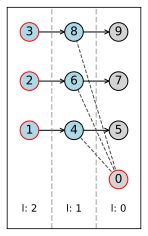

---------------------- 
Now executing the optimisation on the JCZ...
----------------------
Folder 'layers/' has been emptied.
--------------- 
Currently generate_graph_state, Below is JCZ conversion in pyZX graph


-------------- 
Below is the JCZ pyZX in graph form


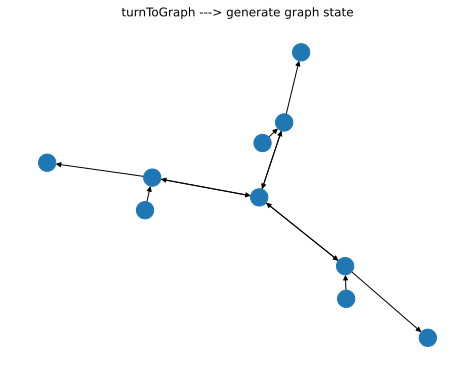

2.Node index: 1, Node attribute {'node_val': 'In', 'pos': (0, -1), 'phase': 0, 'gate_name': 'CNOT'}
2.Node index: 2, Node attribute {'node_val': 'Aux', 'pos': (3, -1), 'phase': 0, 'gate_name': 'CNOT'}
2.Node index: 3, Node attribute {'node_val': 'IO', 'pos': (6, 0), 'phase': -1, 'gate_name': 'CNOT'}
2.Node index: 4, Node attribute {'node_val': 'Out', 'pos': (9, -1), 'phase': -1, 'gate_name': 'CNOT'}
2.Node index: 5, Node attribute {'node_val': 'In', 'pos': (12, -2), 'phase': 0, 'gate_name': 'CNOT'}
2.Node index: 6, Node attribute {'node_val': 'Aux', 'pos': (15, -2), 'phase': 0, 'gate_name': 'CNOT'}
2.Node index: 7, Node attribute {'node_val': 'Out', 'pos': (18, -2), 'phase': -1, 'gate_name': 'CNOT'}
2.Node index: 8, Node attribute {'node_val': 'In', 'pos': (21, -3), 'phase': 0, 'gate_name': 'CNOT'}
2.Node index: 9, Node attribute {'node_val': 'Aux', 'pos': (24, -3), 'phase': 0, 'gate_name': 'CNOT'}
2.Node index: 10, Node attribute {'node_val': 'Out', 'pos': (27, -3), 'phase': -1, 'gate

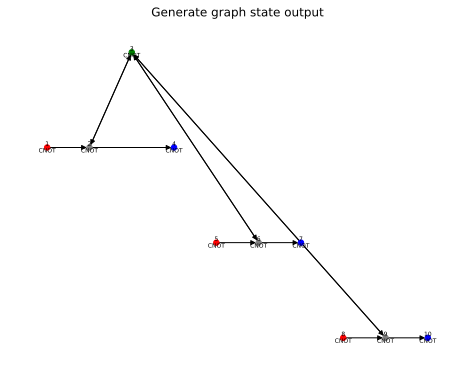

Added X dependency
Added X dependency
Added X dependency
Added X dependency
Added X dependency
Added X dependency
-------------- 
Below is determine_dependency result 
-------------- 
-------------- 
Step 1.) determined_graph
-------------- 


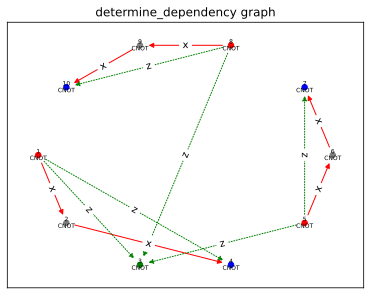

-------------- 
Step 2.) reduce_redudancy
-------------- 


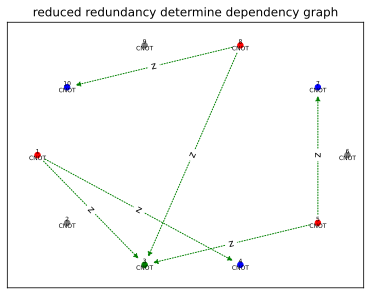

-------------- 
Step 3.) signal shifted determine dependency graph
-------------- 
shift signal finished


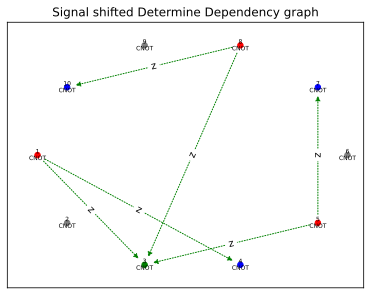

-------------- 
Below is undirected_graph result


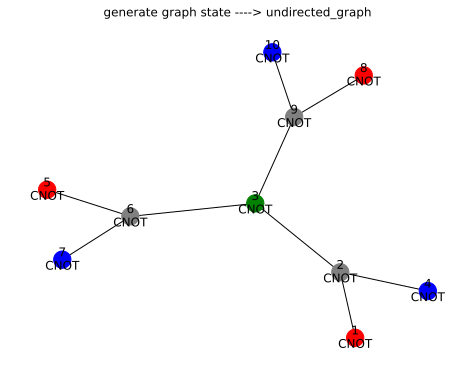

--------------
Below is randomised resource_state 


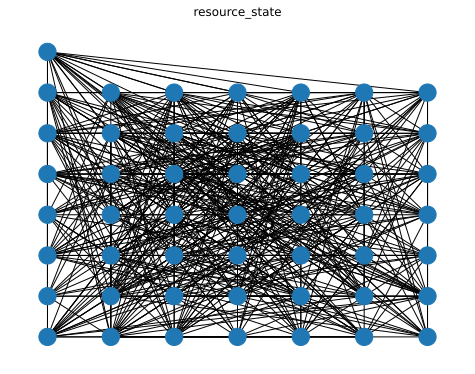

The depth [2, 2, 2, 2, 2, 2, 3], Max degree, 7, Max length 8
fusion connected qubits validation success!


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/networkx/drawing/nx_pylab.py:305: UserWarning: 

The arrowsize keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default value for arrowsize.
Note that using FancyArrowPatches may be slow for large graphs.

  draw_networkx_edges(G, pos, arrows=arrows, **edge_kwds)


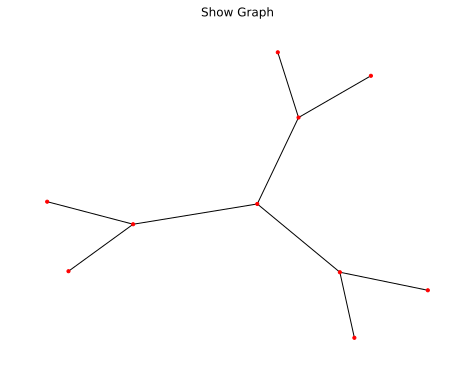

--------------
Below undirected_graph + resource_state = fusion graph AKA pre_graph 
Graph with 10 nodes and 9 edges


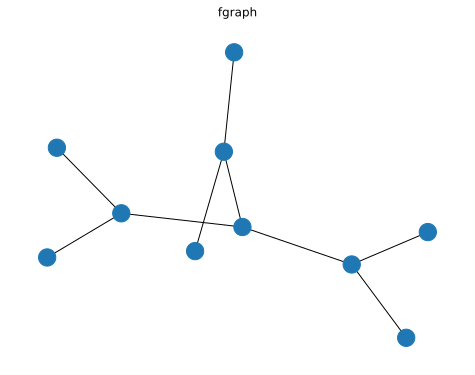

--------------
Below fgraph & dgraph & rs input to map & route 
9 9


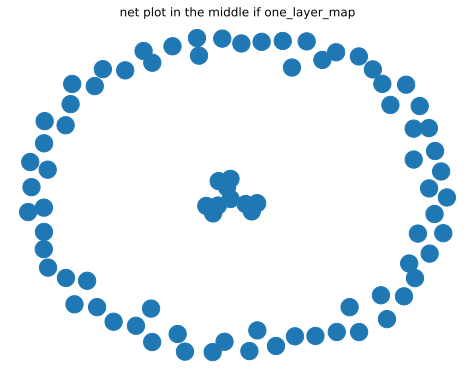

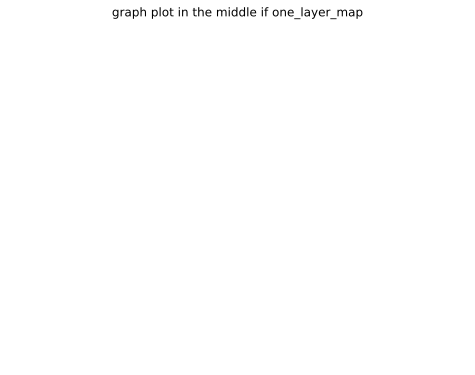

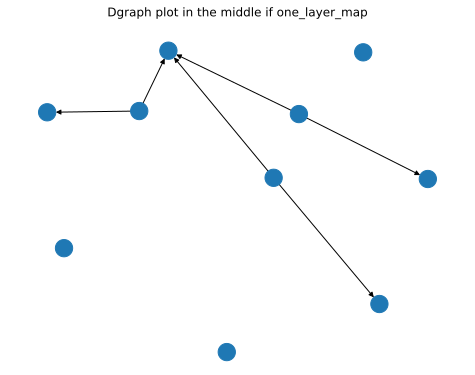

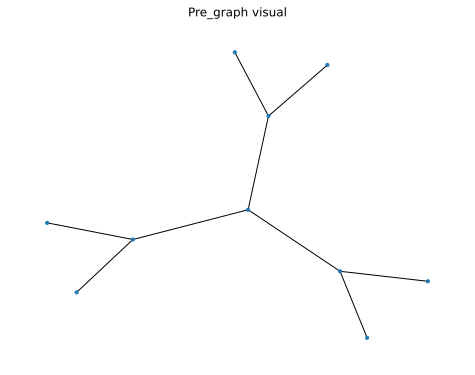

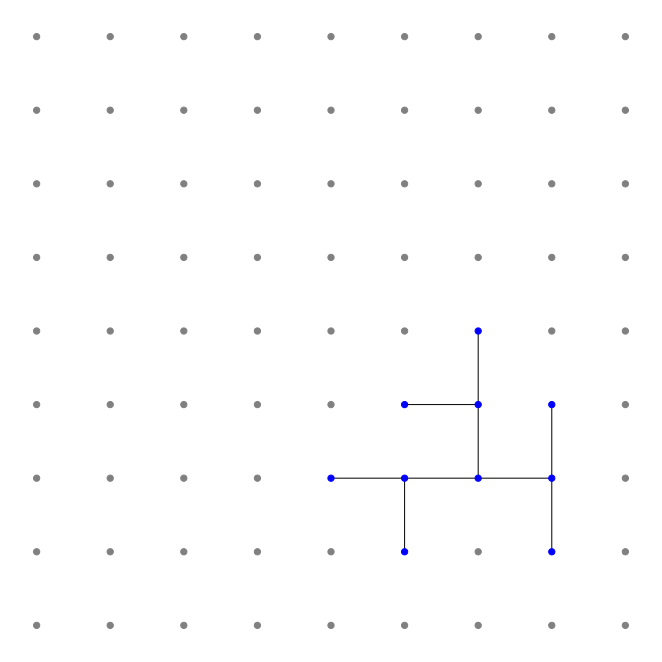

0
10 nodes
1 layers
fusion: 9
connect qubits validation success!
[{0: (0, 0), 1: (1, 0), 2: (2, 0), 3: (3, 0), 4: (4, 0), 5: (5, 0), 6: (6, 0), 7: (7, 0), 8: (8, 0), 9: (0, 1), 10: (1, 1), 11: (2, 1), 12: (3, 1), 13: (4, 1), 14: (5, 1), 15: (6, 1), 16: (7, 1), 17: (8, 1), 18: (0, 2), 19: (1, 2), 20: (2, 2), 21: (3, 2), 22: (4, 2), 23: (5, 2), 24: (6, 2), 25: (7, 2), 26: (8, 2), 27: (0, 3), 28: (1, 3), 29: (2, 3), 30: (3, 3), 31: (4, 3), 32: (5, 3), 33: (6, 3), 34: (7, 3), 35: (8, 3), 36: (0, 4), 37: (1, 4), 38: (2, 4), 39: (3, 4), 40: (4, 4), 41: (5, 4), 42: (6, 4), 43: (7, 4), 44: (8, 4), 45: (0, 5), 46: (1, 5), 47: (2, 5), 48: (3, 5), 49: (4, 5), 50: (5, 5), 51: (6, 5), 52: (7, 5), 53: (8, 5), 54: (0, 6), 55: (1, 6), 56: (2, 6), 57: (3, 6), 58: (4, 6), 59: (5, 6), 60: (6, 6), 61: (7, 6), 62: (8, 6), 63: (0, 7), 64: (1, 7), 65: (2, 7), 66: (3, 7), 67: (4, 7), 68: (5, 7), 69: (6, 7), 70: (7, 7), 71: (8, 7), 72: (0, 8), 73: (1, 8), 74: (2, 8), 75: (3, 8), 76: (4, 8), 77: (5, 8), 78: (6,

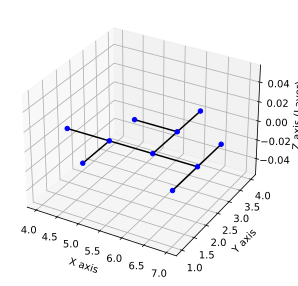

In [22]:
############################################
# 4. Executing optimisation
############################################
print('---------------------- \nBelow is the pyZX plot of the circuit\n----------------------' )
c = test_circuit.to_graph()
zx.draw(c)

graphix_circ = pyZX_to_graphix(test_circuit, test_circuit.qubits)
pattern = graphix_circ.transpile()
pattern.draw_graph()

print('---------------------- \nNow executing the optimisation on the JCZ...\n----------------------')
NxM = 9,9
custom_main(jcz_circuit.gates, test_circuit.qubits, NxM , 50, prob=0.4)
#zx.draw(test_circuit)

In [23]:
from pyzx.routing import *

nqubit = 8
simple_circuit = zx.Circuit(qubit_amount=nqubit)
simple_circuit.add_gate("CNOT", 0, 1)
simple_circuit.add_gate("CNOT", 0, 2)
circuit_to_be_compiled = simple_circuit
architecture = create_architecture(name= "square", n_qubits=4)
 
#create_square_architecture()
compiled_circuit = route_phase_poly(
    circuit_to_be_compiled,
    architecture,
    method=RoutingMethod.GRAY_MEIJER,
    mode=ElimMode.STEINER_MODE,
    root_heuristic=RootHeuristic.RECURSIVE,
    split_heuristic=SplitHeuristic.COUNT)

print(compiled_circuit)

Circuit(4 qubits, 0 bits, 3 gates)


In [24]:
###########################################################
# MISC code, functions for to_rg and to_gh from source code
###########################################################
#from zx.utils import EdgeType, VertexType, toggle_edge, vertex_is_zx, toggle_vertex

'''
def to_gh(g: BaseGraph[VT,ET],quiet:bool=True) -> None:
    """Turns every red node into a green node by changing regular edges into hadamard edges"""
    ty = g.types()
    for v in g.vertices():
        if ty[v] == VertexType.X:
            g.set_type(v, VertexType.Z)
            for e in g.incident_edges(v):
                et = g.edge_type(e)
                g.set_edge_type(e, toggle_edge(et))

def to_rg(g: BaseGraph[VT,ET], select:Optional[Callable[[VT],bool]]=None) -> None:
    """Turn green nodes into red nodes by color-changing vertices which satisfy the predicate ``select``.
    By default, the predicate is set to greedily reducing the number of Hadamard-edges.
    :param g: A ZX-graph.
    :param select: A function taking in vertices and returning ``True`` or ``False``."""
    if select is None:
        select = lambda v: (
            len([e for e in g.incident_edges(v) if g.edge_type(e) == EdgeType.SIMPLE]) <
            len([e for e in g.incident_edges(v) if g.edge_type(e) == EdgeType.HADAMARD])
            )

    ty = g.types()
    for v in g.vertices():
        if select(v) and vertex_is_zx(ty[v]):
            g.set_type(v, toggle_vertex(ty[v]))
            for e in g.incident_edges(v):
                g.set_edge_type(e, toggle_edge(g.edge_type(e)))
'''


'\ndef to_gh(g: BaseGraph[VT,ET],quiet:bool=True) -> None:\n    """Turns every red node into a green node by changing regular edges into hadamard edges"""\n    ty = g.types()\n    for v in g.vertices():\n        if ty[v] == VertexType.X:\n            g.set_type(v, VertexType.Z)\n            for e in g.incident_edges(v):\n                et = g.edge_type(e)\n                g.set_edge_type(e, toggle_edge(et))\n\ndef to_rg(g: BaseGraph[VT,ET], select:Optional[Callable[[VT],bool]]=None) -> None:\n    """Turn green nodes into red nodes by color-changing vertices which satisfy the predicate ``select``.\n    By default, the predicate is set to greedily reducing the number of Hadamard-edges.\n    :param g: A ZX-graph.\n    :param select: A function taking in vertices and returning ``True`` or ``False``."""\n    if select is None:\n        select = lambda v: (\n            len([e for e in g.incident_edges(v) if g.edge_type(e) == EdgeType.SIMPLE]) <\n            len([e for e in g.incident_edges

{('A', 'B'): Text(9.36174677618102e-05, 0.5000000000000002, 'AB'),
 ('B', 'C'): Text(-8.617586346479459e-05, -0.46023193212247804, 'BC')}

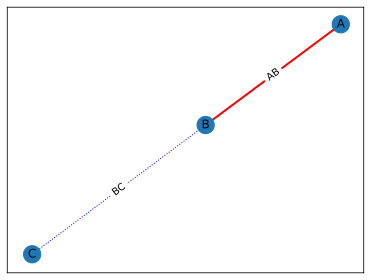

In [25]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a graph
G = nx.Graph()

# Add nodes
G.add_node("A")
G.add_node("B")
G.add_node("C")

# Add edges with different attributes
G.add_edge("A", "B", color='red', weight=2, style='solid', label='AB')
G.add_edge("B", "C", color='blue', weight=1, style='dotted', label='BC')

# Position the nodes using a layout
pos = nx.spring_layout(G)

# Draw the nodes
nx.draw_networkx_nodes(G, pos)

# Draw each edge individually to control styles
for (u, v, d) in G.edges(data=True):
    nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], edge_color=d['color'], width=d['weight'], style=d['style'])

# Draw the labels
nx.draw_networkx_labels(G, pos)
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Show the plot
#plt.show()
